In [ ]:
# 📌 Import PySpark libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, when, isnull
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# 📌 Import other useful libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 📌 Create a Spark Session
spark = SparkSession.builder.appName("HeartDisease_Prediction").getOrCreate()

# 📌 Display Spark Version
print("🔹 PySpark Version:", spark.version)


In [ ]:
# Step 1: Download the dataset from Kaggle
# Note: You can download manually from Kaggle or use kaggle API
# For manual download: Visit https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset
# For API: !pip install kaggle
#          !kaggle datasets download -d johnsmith88/heart-disease-dataset

# For this notebook, we'll assume the dataset is downloaded as 'heart.csv'
# If using Kaggle API, uncomment the following:
# !kaggle datasets download -d johnsmith88/heart-disease-dataset -p /content/
# !unzip -o /content/heart-disease-dataset.zip -d /content/

# Load the dataset into PySpark DataFrame
# Adjust the path according to your environment
try:
    # Try loading from current directory or specified path
    df = spark.read.csv("heart.csv", header=True, inferSchema=True)
    print("✅ Dataset loaded successfully from heart.csv")
except:
    # If file not found, provide instructions
    print("⚠️ Please download the dataset from Kaggle and place it as 'heart.csv' in the current directory")
    print("   Or update the path in the code above")
    # For demonstration, we'll create a sample structure
    print("\n📝 Expected dataset columns:")
    print("   age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal, target")


In [ ]:
# Display basic dataset information
if 'df' in locals():
    print("📊 Dataset Schema:")
    df.printSchema()
    print("\n📊 Dataset Shape (Rows, Columns):", (df.count(), len(df.columns)))
    print("\n📊 Column Names:")
    print(df.columns)


In [ ]:
# 2a. Print first 5 rows for sanity check
if 'df' in locals():
    print("📌 First 5 Rows of the Dataset:")
    df.show(5, truncate=False)

    # Convert to Pandas for easier visualization (for small datasets)
    df_pd = df.toPandas()
    print("\n📌 First 5 Rows (Pandas view):")
    print(df_pd.head())

    # Identify target variable
    print("\n📌 Target Variable: 'target' (0 = No heart disease, 1 = Heart disease present)")
    print("📌 Features present in the dataset:")
    for col_name in df.columns:
        if col_name != 'target':
            print(f"   - {col_name}")


In [ ]:
# 2b. Print dataset description and shape
if 'df' in locals():
    print("📌 Dataset Shape:")
    num_rows = df.count()
    num_cols = len(df.columns)
    print(f"   Rows: {num_rows}")
    print(f"   Columns: {num_cols}")

    print("\n📌 Dataset Description (Summary Statistics):")
    df_pd = df.toPandas()
    print(df_pd.describe())

    print("\n📌 Data Types:")
    df.printSchema()

    print("\n📌 Missing Values Check:")
    from pyspark.sql.functions import col, sum as spark_sum
    missing_counts = df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
    missing_counts.show()


In [ ]:
# 2c. Visualizations - Class Distribution
if 'df' in locals():
    df_pd = df.toPandas()

    # Class distribution - Bar chart
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    class_counts = df_pd['target'].value_counts().sort_index()
    plt.bar(['No Disease (0)', 'Heart Disease (1)'], class_counts.values, color=['skyblue', 'salmon'])
    plt.title('Class Distribution - Heart Disease Dataset')
    plt.xlabel('Target Class')
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.3)

    # Class distribution - Pie chart
    plt.subplot(1, 2, 2)
    plt.pie(class_counts.values, labels=['No Disease (0)', 'Heart Disease (1)'],
            autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=90)
    plt.title('Class Distribution - Percentage')

    plt.tight_layout()
    plt.show()

    print("📌 Class Distribution Counts:")
    print(class_counts)
    print(f"\n📌 Class Balance Ratio: {min(class_counts.values) / max(class_counts.values):.3f}")


In [ ]:
# 2c. Visualizations - Feature Distributions (Histograms)
if 'df' in locals():
    df_pd = df.toPandas()

    # Select numerical features for visualization
    numerical_cols = df_pd.select_dtypes(include=[np.number]).columns.tolist()
    if 'target' in numerical_cols:
        numerical_cols.remove('target')

    # Create histograms for numerical features
    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

    for idx, col_name in enumerate(numerical_cols[:len(axes)]):
        axes[idx].hist(df_pd[col_name].dropna(), bins=30, edgecolor='black', color='skyblue', alpha=0.7)
        axes[idx].set_title(f'Distribution of {col_name}')
        axes[idx].set_xlabel(col_name)
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(alpha=0.3)

    # Hide empty subplots
    for idx in range(len(numerical_cols), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


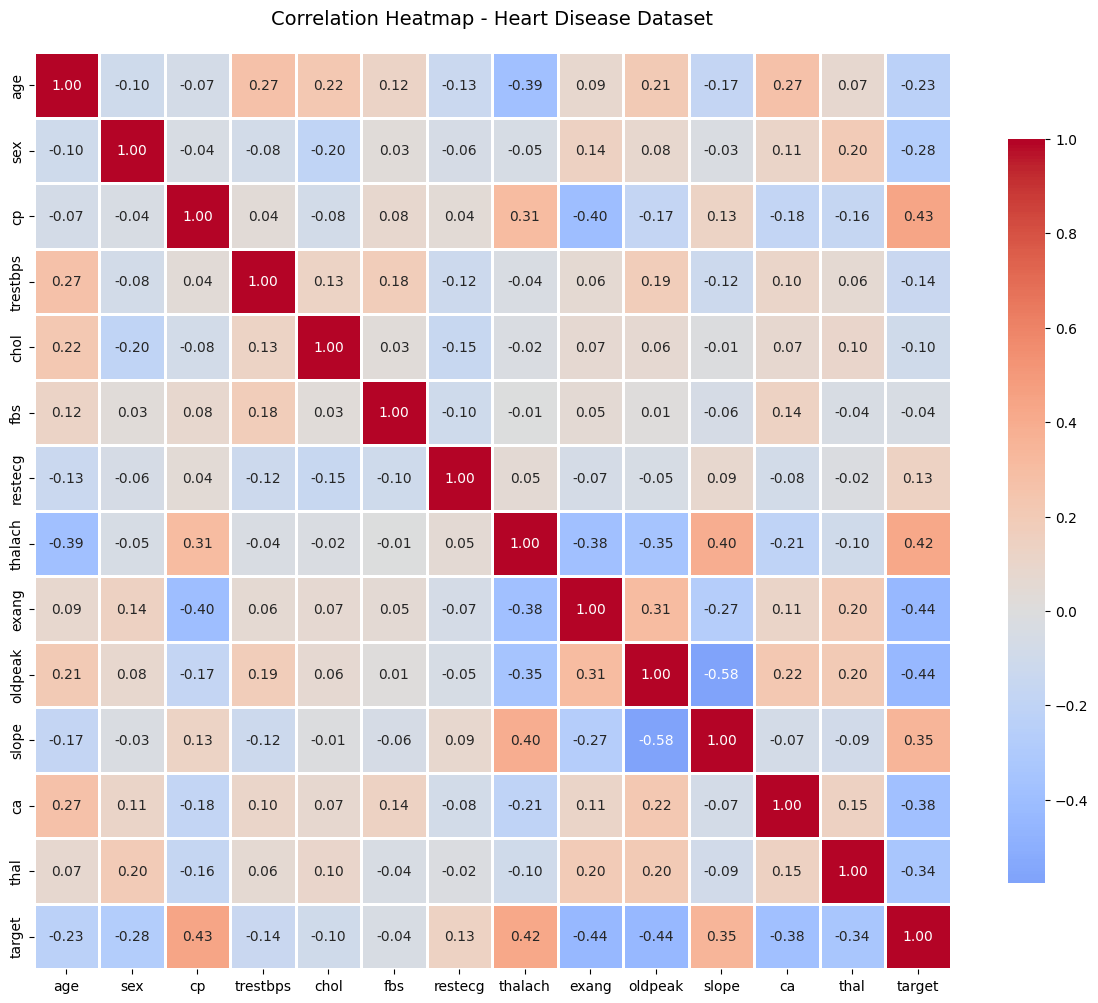

📌 Highly Correlated Feature Pairs (|correlation| > 0.5):
   oldpeak <-> slope: -0.575


In [40]:
# 2c. Visualizations - Correlation Heatmap
if 'df' in locals():
    df_pd = df.toPandas()

    # Calculate correlation matrix
    numerical_cols = df_pd.select_dtypes(include=[np.number]).columns.tolist()
    corr_matrix = df_pd[numerical_cols].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Heatmap - Heart Disease Dataset', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

    # Identify highly correlated features
    print("📌 Highly Correlated Feature Pairs (|correlation| > 0.5):")
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.5:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

    if high_corr_pairs:
        for feat1, feat2, corr_val in high_corr_pairs:
            print(f"   {feat1} <-> {feat2}: {corr_val:.3f}")
    else:
        print("   No highly correlated pairs found (threshold: 0.5)")


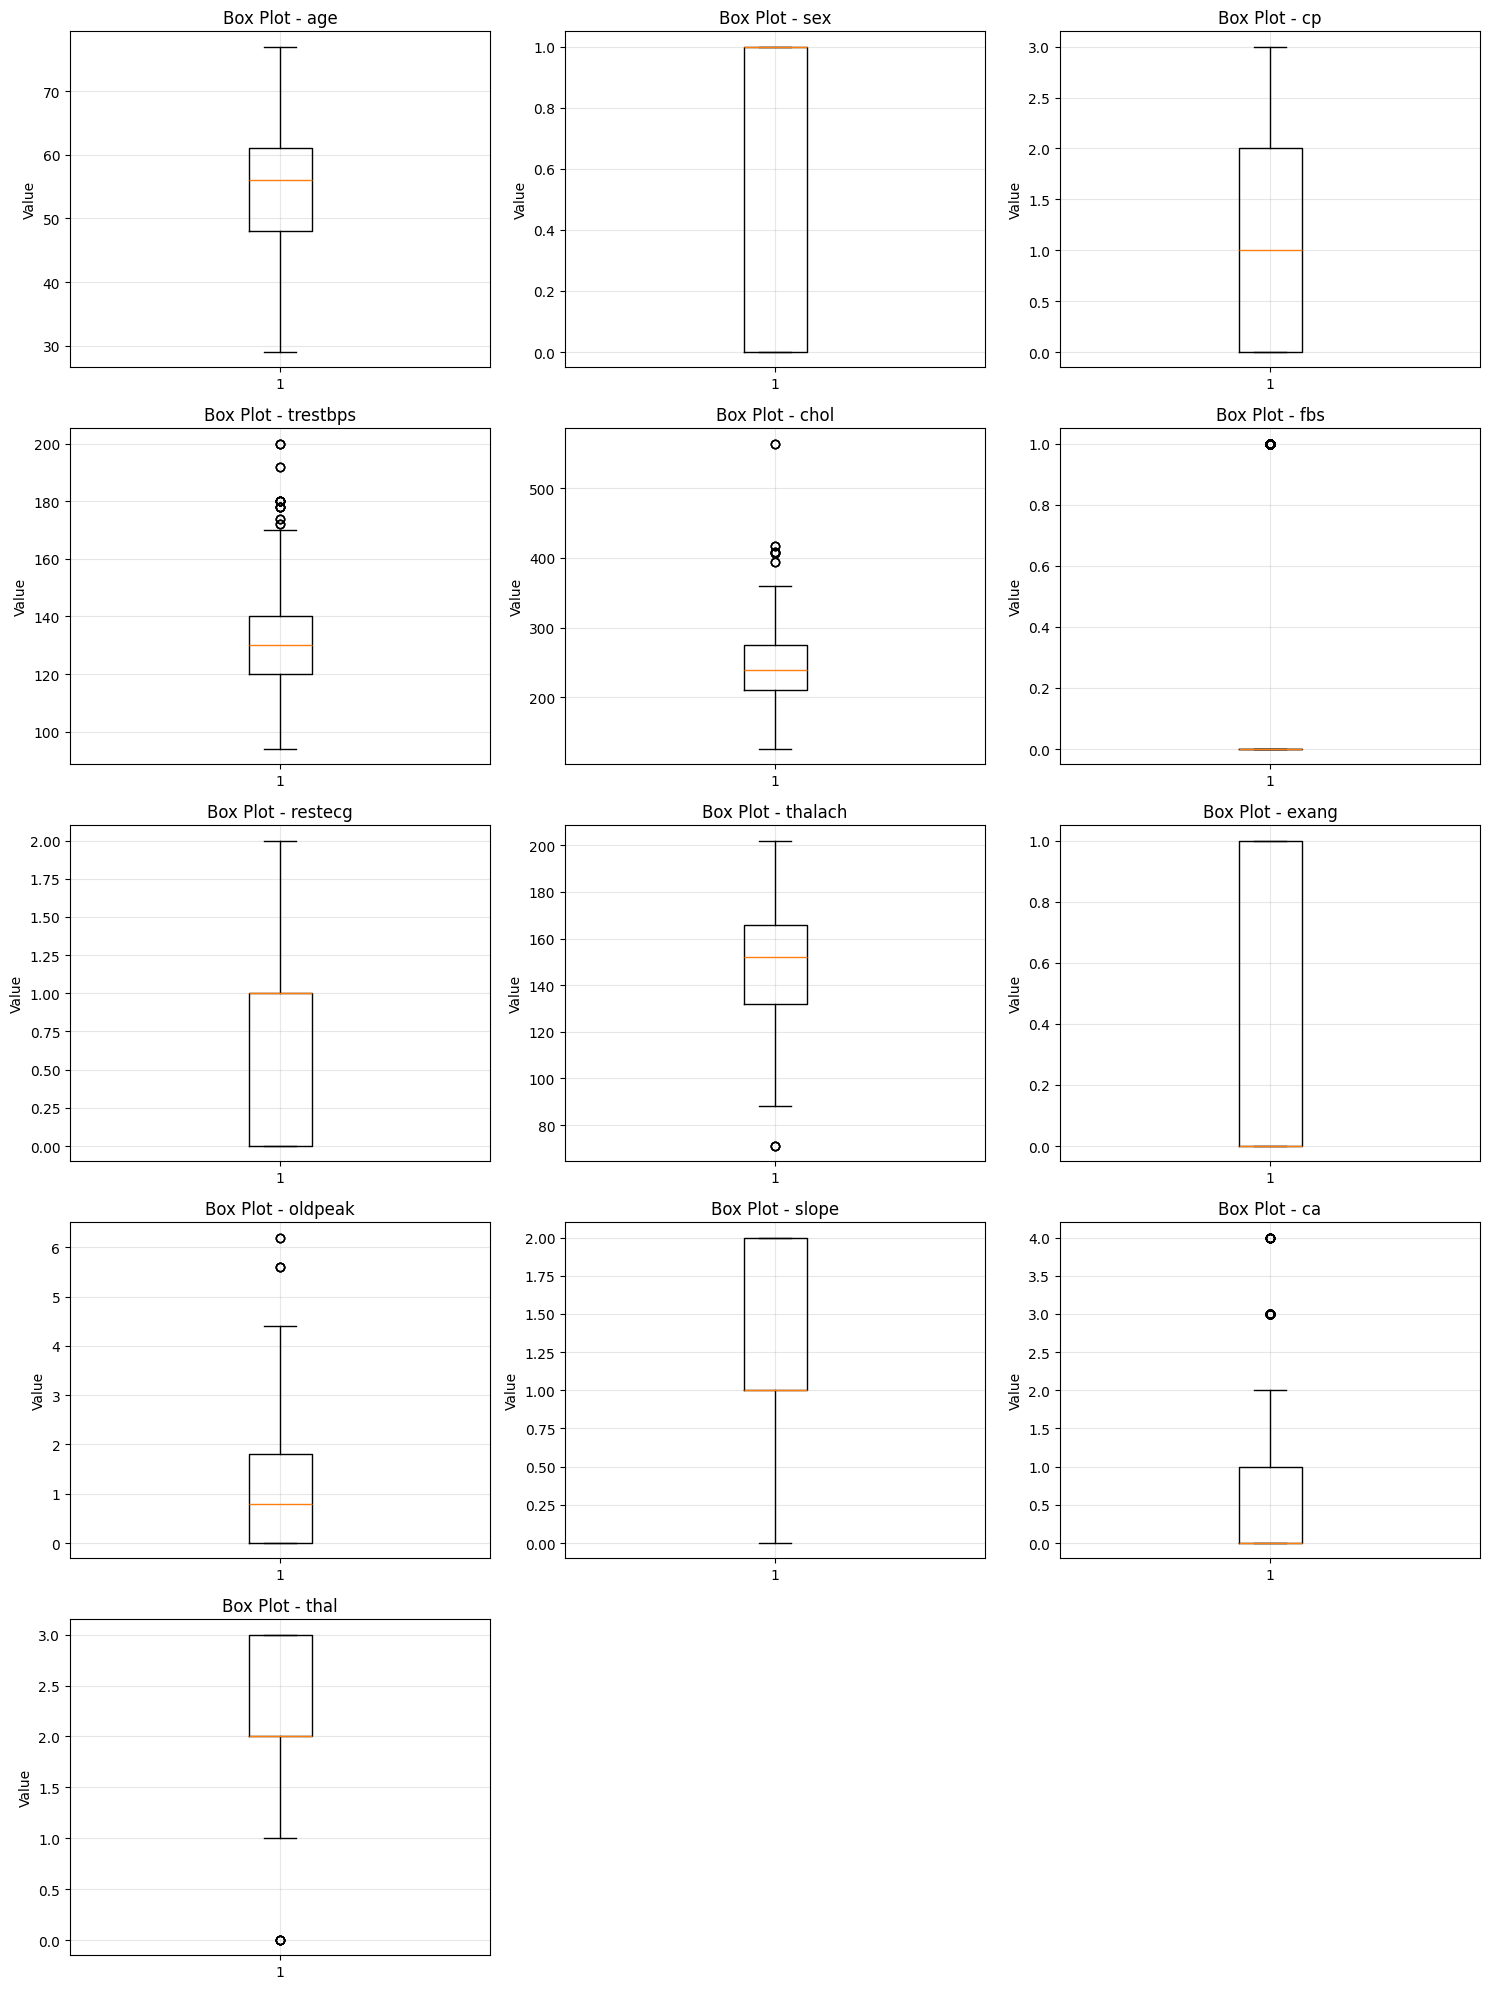

In [41]:
# 2c. Visualizations - Box Plots for Outlier Detection
if 'df' in locals():
    df_pd = df.toPandas()

    numerical_cols = df_pd.select_dtypes(include=[np.number]).columns.tolist()
    if 'target' in numerical_cols:
        numerical_cols.remove('target')

    # Create box plots
    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

    for idx, col_name in enumerate(numerical_cols[:len(axes)]):
        axes[idx].boxplot(df_pd[col_name].dropna(), vert=True)
        axes[idx].set_title(f'Box Plot - {col_name}')
        axes[idx].set_ylabel('Value')
        axes[idx].grid(alpha=0.3)

    # Hide empty subplots
    for idx in range(len(numerical_cols), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


In [42]:
# 2d. Data Insights and Exploration
if 'df' in locals():
    df_pd = df.toPandas()

    print("📌 Data Insights Summary:")
    print("=" * 60)

    print("\n1. Dataset Overview:")
    print(f"   - Total Records: {len(df_pd)}")
    print(f"   - Total Features: {len(df_pd.columns) - 1}")  # Excluding target
    print(f"   - Target Variable: 'target' (Binary Classification)")

    print("\n2. Class Balance Analysis:")
    class_counts = df_pd['target'].value_counts().sort_index()
    print(f"   - Class 0 (No Disease): {class_counts[0]} ({class_counts[0]/len(df_pd)*100:.1f}%)")
    print(f"   - Class 1 (Heart Disease): {class_counts[1]} ({class_counts[1]/len(df_pd)*100:.1f}%)")
    balance_ratio = min(class_counts.values) / max(class_counts.values)
    if balance_ratio > 0.8:
        print(f"   - Dataset is balanced (ratio: {balance_ratio:.3f})")
    else:
        print(f"   - Dataset is imbalanced (ratio: {balance_ratio:.3f})")

    print("\n3. Missing Values:")
    missing = df_pd.isnull().sum()
    if missing.sum() == 0:
        print("   ✅ No missing values found in the dataset")
    else:
        print("   ⚠️ Missing values detected:")
        for col, count in missing[missing > 0].items():
            print(f"      - {col}: {count} ({count/len(df_pd)*100:.2f}%)")

    print("\n4. Feature Statistics:")
    numerical_cols = df_pd.select_dtypes(include=[np.number]).columns.tolist()
    if 'target' in numerical_cols:
        numerical_cols.remove('target')
    print(f"   - Numerical Features: {len(numerical_cols)}")
    print(f"   - Categorical Features: {len(df_pd.columns) - len(numerical_cols) - 1}")

    print("\n5. Data Types:")
    for col in df_pd.columns:
        dtype = df_pd[col].dtype
        print(f"   - {col}: {dtype}")

    print("\n" + "=" * 60)


📌 Data Insights Summary:

1. Dataset Overview:
   - Total Records: 1025
   - Total Features: 13
   - Target Variable: 'target' (Binary Classification)

2. Class Balance Analysis:
   - Class 0 (No Disease): 499 (48.7%)
   - Class 1 (Heart Disease): 526 (51.3%)
   - Dataset is balanced (ratio: 0.949)

3. Missing Values:
   ✅ No missing values found in the dataset

4. Feature Statistics:
   - Numerical Features: 13
   - Categorical Features: 0

5. Data Types:
   - age: int32
   - sex: int32
   - cp: int32
   - trestbps: int32
   - chol: int32
   - fbs: int32
   - restecg: int32
   - thalach: int32
   - exang: int32
   - oldpeak: float64
   - slope: int32
   - ca: int32
   - thal: int32
   - target: int32



In [43]:
# 3a. Check for NULL or Missing Values
if 'df' in locals():
    print("📌 Checking for Missing Values:")
    from pyspark.sql.functions import col, sum as spark_sum, when, isnan, isnull

    # Count missing values for each column
    missing_counts = df.select([spark_sum(when(isnan(c) | isnull(c), 1).otherwise(0)).alias(c)
                                for c in df.columns])
    missing_counts.show()

    # Convert to pandas for easier analysis
    missing_pd = missing_counts.toPandas()
    total_missing = missing_pd.sum(axis=1).values[0]

    if total_missing == 0:
        print("✅ No missing values found in the dataset")
        df_cleaned = df  # No cleaning needed
    else:
        print(f"⚠️ Total missing values: {total_missing}")
        print("📌 Handling missing values...")
        # Option 1: Drop rows with missing values
        # df_cleaned = df.dropna()
        # Option 2: Fill missing values (example for numerical columns)
        # df_cleaned = df.fillna(0)  # or use mean/median
        # For now, we'll drop rows with any missing values
        df_cleaned = df.dropna()
        print(f"✅ Removed rows with missing values. New shape: ({df_cleaned.count()}, {len(df_cleaned.columns)})")

    # Store cleaned dataframe
    df = df_cleaned


📌 Checking for Missing Values:
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+

✅ No missing values found in the dataset


In [44]:
# 3a. Outlier Detection and Handling
if 'df' in locals():
    df_pd = df.toPandas()
    numerical_cols = df_pd.select_dtypes(include=[np.number]).columns.tolist()
    if 'target' in numerical_cols:
        numerical_cols.remove('target')

    print("📌 Outlier Detection using IQR Method:")
    print("=" * 60)

    outliers_info = {}
    for col_name in numerical_cols:
        Q1 = df_pd[col_name].quantile(0.25)
        Q3 = df_pd[col_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df_pd[(df_pd[col_name] < lower_bound) | (df_pd[col_name] > upper_bound)]
        outlier_count = len(outliers)

        if outlier_count > 0:
            outliers_info[col_name] = {
                'count': outlier_count,
                'percentage': (outlier_count / len(df_pd)) * 100,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
            print(f"\n{col_name}:")
            print(f"  - Outliers found: {outlier_count} ({(outlier_count/len(df_pd)*100):.2f}%)")
            print(f"  - Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")

    if not outliers_info:
        print("✅ No significant outliers detected using IQR method")
    else:
        print(f"\n⚠️ Total features with outliers: {len(outliers_info)}")
        print("📌 Note: For this dataset, we'll keep outliers as they may represent valid medical conditions")
        print("   (e.g., extreme cholesterol levels or blood pressure can be legitimate medical data)")

    print("=" * 60)


📌 Outlier Detection using IQR Method:

trestbps:
  - Outliers found: 30 (2.93%)
  - Lower bound: 90.00, Upper bound: 170.00

chol:
  - Outliers found: 16 (1.56%)
  - Lower bound: 115.00, Upper bound: 371.00

fbs:
  - Outliers found: 153 (14.93%)
  - Lower bound: 0.00, Upper bound: 0.00

thalach:
  - Outliers found: 4 (0.39%)
  - Lower bound: 81.00, Upper bound: 217.00

oldpeak:
  - Outliers found: 7 (0.68%)
  - Lower bound: -2.70, Upper bound: 4.50

ca:
  - Outliers found: 87 (8.49%)
  - Lower bound: -1.50, Upper bound: 2.50

thal:
  - Outliers found: 7 (0.68%)
  - Lower bound: 0.50, Upper bound: 4.50

⚠️ Total features with outliers: 7
📌 Note: For this dataset, we'll keep outliers as they may represent valid medical conditions
   (e.g., extreme cholesterol levels or blood pressure can be legitimate medical data)


In [45]:
# 3a. Check for Data Skewness
if 'df' in locals():
    df_pd = df.toPandas()
    numerical_cols = df_pd.select_dtypes(include=[np.number]).columns.tolist()
    if 'target' in numerical_cols:
        numerical_cols.remove('target')

    print("📌 Checking Data Skewness:")
    print("=" * 60)

    from scipy import stats

    skewness_info = {}
    for col_name in numerical_cols:
        skewness = stats.skew(df_pd[col_name].dropna())
        skewness_info[col_name] = skewness

        if abs(skewness) > 1:
            skew_label = "Highly Skewed" if abs(skewness) > 2 else "Moderately Skewed"
            direction = "Right" if skewness > 0 else "Left"
            print(f"{col_name}: {skewness:.3f} ({skew_label}, {direction})")

    highly_skewed = [col for col, skew in skewness_info.items() if abs(skew) > 1]

    if not highly_skewed:
        print("✅ No highly skewed features detected (all |skewness| < 1)")
    else:
        print(f"\n⚠️ Features with significant skewness: {len(highly_skewed)}")
        print("📌 Note: We'll apply transformations if needed during feature engineering")

    print("=" * 60)


📌 Checking Data Skewness:
chol: 1.073 (Moderately Skewed, Right)
fbs: 1.968 (Moderately Skewed, Right)
oldpeak: 1.209 (Moderately Skewed, Right)
ca: 1.259 (Moderately Skewed, Right)

⚠️ Features with significant skewness: 4
📌 Note: We'll apply transformations if needed during feature engineering


In [46]:
# 3a. Handle Categorical Variables using StringIndexer
if 'df' in locals():
    print("📌 Handling Categorical Variables:")

    # Identify categorical columns (non-numeric or with limited unique values)
    df_pd = df.toPandas()
    categorical_cols = []

    for col in df.columns:
        if col != 'target':
            unique_count = df.select(col).distinct().count()
            # Consider columns with < 20 unique values as categorical
            if unique_count < 20:
                categorical_cols.append(col)

    print(f"📌 Categorical columns identified: {categorical_cols}")

    # Note: For the Heart Disease dataset, most features are already encoded as integers
    # If there are string categoricals, we would use StringIndexer here
    # Example:
    # indexer = StringIndexer(inputCol="categorical_col", outputCol="categorical_col_indexed")
    # df = indexer.fit(df).transform(df)

    print("✅ Categorical variables handled (dataset already has encoded categoricals)")

    # Display unique values for categorical-like columns
    print("\n📌 Unique value counts for categorical-like features:")
    for col in categorical_cols[:5]:  # Show first 5
        unique_vals = df.select(col).distinct().collect()
        print(f"   {col}: {[row[col] for row in unique_vals]}")


📌 Handling Categorical Variables:
📌 Categorical columns identified: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
✅ Categorical variables handled (dataset already has encoded categoricals)

📌 Unique value counts for categorical-like features:
   sex: [1, 0]
   cp: [1, 3, 2, 0]
   fbs: [1, 0]
   restecg: [1, 2, 0]
   exang: [1, 0]


In [47]:
# 3b. Feature Transformation - Standardization using StandardScaler
if 'df' in locals():
    print("📌 Applying Feature Transformation:")

    # First, prepare feature columns (exclude target)
    feature_cols = [col for col in df.columns if col != 'target']

    print(f"📌 Feature columns to transform: {feature_cols}")

    # Use VectorAssembler to combine features into a single vector column
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df_assembled = assembler.transform(df)

    print("✅ Features assembled into vector column")

    # Apply StandardScaler for standardization
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                           withStd=True, withMean=True)
    scaler_model = scaler.fit(df_assembled)
    df_scaled = scaler_model.transform(df_assembled)

    print("✅ Features standardized using StandardScaler (mean=0, std=1)")

    # Display schema to confirm transformations
    print("\n📌 Updated Schema:")
    df_scaled.select("features", "scaled_features", "target").show(5, truncate=False)

    # Store the processed dataframe
    df_processed = df_scaled


📌 Applying Feature Transformation:
📌 Feature columns to transform: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
✅ Features assembled into vector column
✅ Features standardized using StandardScaler (mean=0, std=1)

📌 Updated Schema:
+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|features                                                    |scaled_features                                                                                                                                                                                                                                                 |target|
+---------------------------------------------

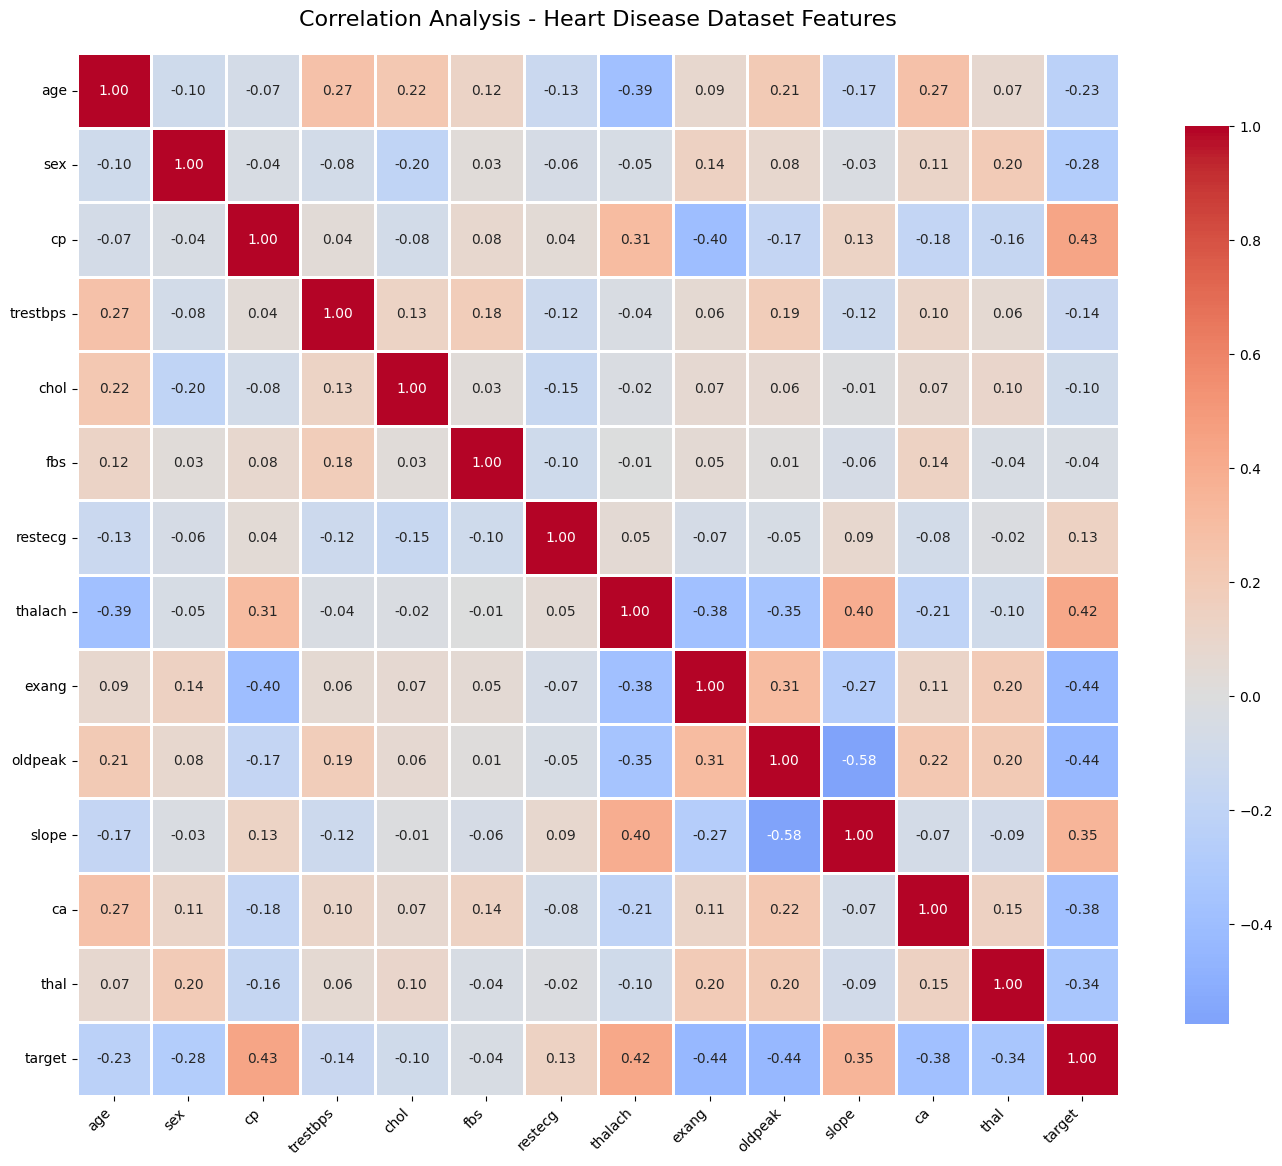

📌 Correlation with Target Variable:

Top Positive Correlations with Target:
   cp: 0.435
   thalach: 0.423
   slope: 0.346
   restecg: 0.134
   fbs: -0.041

Top Negative Correlations with Target:
   sex: -0.280
   thal: -0.338
   ca: -0.382
   exang: -0.438
   oldpeak: -0.438

📌 Highly Correlated Feature Pairs (|correlation| > 0.5, excluding target):
   oldpeak <-> slope: -0.575


In [48]:
# 3c. Correlation Analysis with Visualization
if 'df' in locals():
    df_pd = df.toPandas()
    numerical_cols = df_pd.select_dtypes(include=[np.number]).columns.tolist()

    # Calculate correlation matrix
    corr_matrix = df_pd[numerical_cols].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8},
                xticklabels=True, yticklabels=True)
    plt.title('Correlation Analysis - Heart Disease Dataset Features', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Analyze correlation with target variable
    print("📌 Correlation with Target Variable:")
    print("=" * 60)
    target_corr = corr_matrix['target'].sort_values(ascending=False)

    # Remove target's correlation with itself
    target_corr = target_corr[target_corr.index != 'target']

    print("\nTop Positive Correlations with Target:")
    for feature, corr_val in target_corr.head(5).items():
        print(f"   {feature}: {corr_val:.3f}")

    print("\nTop Negative Correlations with Target:")
    for feature, corr_val in target_corr.tail(5).items():
        print(f"   {feature}: {corr_val:.3f}")

    # Identify highly correlated feature pairs
    print("\n📌 Highly Correlated Feature Pairs (|correlation| > 0.5, excluding target):")
    high_corr_pairs = []
    feature_cols_only = [col for col in numerical_cols if col != 'target']

    for i in range(len(feature_cols_only)):
        for j in range(i+1, len(feature_cols_only)):
            feat1 = feature_cols_only[i]
            feat2 = feature_cols_only[j]
            corr_val = corr_matrix.loc[feat1, feat2]
            if abs(corr_val) > 0.5:
                high_corr_pairs.append((feat1, feat2, corr_val))

    if high_corr_pairs:
        for feat1, feat2, corr_val in high_corr_pairs:
            print(f"   {feat1} <-> {feat2}: {corr_val:.3f}")
    else:
        print("   No highly correlated feature pairs found (threshold: 0.5)")

    print("=" * 60)


In [49]:
# 4a. Feature Selection - Extract features (X) and target (Y)
if 'df_processed' in locals():
    print("📌 Feature Selection:")

    # The features are already assembled in 'scaled_features' column
    # Target variable is 'target'

    # Apply StringIndexer to target if needed (for consistency)
    # Note: For binary classification, target is usually already 0/1
    indexer = StringIndexer(inputCol="target", outputCol="label")
    df_indexed = indexer.fit(df_processed).transform(df_processed)

    print("✅ Target variable indexed as 'label'")
    print("✅ Features are in 'scaled_features' column")

    # Display sample to verify
    print("\n📌 Sample data with features and label:")
    df_indexed.select("scaled_features", "label", "target").show(5, truncate=False)

    # Store final prepared dataframe
    df_final = df_indexed.select("scaled_features", "label")

    print(f"\n📌 Final dataset shape: ({df_final.count()}, {len(df_final.columns)})")
    print("📌 Features (X): 'scaled_features' - Vector of standardized features")
    print("📌 Target (Y): 'label' - Binary classification label (0 or 1)")

elif 'df' in locals():
    # If df_processed doesn't exist, create it from df
    print("📌 Preparing features from original dataframe...")

    # Get feature columns
    feature_cols = [col for col in df.columns if col != 'target']

    # Assemble features
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df_assembled = assembler.transform(df)

    # Scale features
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                           withStd=True, withMean=True)
    scaler_model = scaler.fit(df_assembled)
    df_scaled = scaler_model.transform(df_assembled)

    # Index target
    indexer = StringIndexer(inputCol="target", outputCol="label")
    df_indexed = indexer.fit(df_scaled).transform(df_scaled)

    df_final = df_indexed.select("scaled_features", "label")
    print("✅ Features prepared and target indexed")
    print(f"📌 Final dataset shape: ({df_final.count()}, {len(df_final.columns)})")


📌 Feature Selection:
✅ Target variable indexed as 'label'
✅ Features are in 'scaled_features' column

📌 Sample data with features and label:
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+------+
|scaled_features                                                                                                                                                                                                                                                 |label|target|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+------+
|[-0.2683056073915854,0.6611813238408427,-0

In [50]:
# 4b. Split dataset into training and test sets
if 'df_final' in locals():
    print("📌 Splitting Dataset into Training and Test Sets:")

    # Split using randomSplit (80-20 split)
    train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

    print(f"✅ Dataset split completed")
    print(f"📌 Training set: {train_data.count()} rows ({train_data.count()/df_final.count()*100:.1f}%)")
    print(f"📌 Test set: {test_data.count()} rows ({test_data.count()/df_final.count()*100:.1f}%)")

    # Display class distribution in train and test sets
    print("\n📌 Class Distribution in Training Set:")
    train_data.groupBy("label").count().orderBy("label").show()

    print("📌 Class Distribution in Test Set:")
    test_data.groupBy("label").count().orderBy("label").show()

    print("\n✅ Data preparation complete!")
    print("   - Features (X): 'scaled_features' column")
    print("   - Target (Y): 'label' column")
    print("   - Training and test sets ready for model building")

else:
    print("⚠️ Please run the previous cells to prepare the data first")


📌 Splitting Dataset into Training and Test Sets:
✅ Dataset split completed
📌 Training set: 856 rows (83.5%)
📌 Test set: 169 rows (16.5%)

📌 Class Distribution in Training Set:
+-----+-----+
|label|count|
+-----+-----+
|  0.0|  448|
|  1.0|  408|
+-----+-----+

📌 Class Distribution in Test Set:
+-----+-----+
|label|count|
+-----+-----+
|  0.0|   78|
|  1.0|   91|
+-----+-----+


✅ Data preparation complete!
   - Features (X): 'scaled_features' column
   - Target (Y): 'label' column
   - Training and test sets ready for model building


In [51]:
# 5a. Model 1: Logistic Regression
if 'train_data' in locals() and 'test_data' in locals():
    print("=" * 60)
    print("🔹 Model 1: Logistic Regression")
    print("=" * 60)

    # Initialize Logistic Regression Model
    lr = LogisticRegression(featuresCol="scaled_features", labelCol="label", maxIter=100)

    # Train the model
    print("📌 Training Logistic Regression model...")
    lr_model = lr.fit(train_data)
    print("✅ Model training completed")

    # Make predictions on training data
    lr_train_predictions = lr_model.transform(train_data)

    # Evaluate training accuracy
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    lr_train_accuracy = evaluator.evaluate(lr_train_predictions)

    # Calculate additional metrics
    lr_train_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision").evaluate(lr_train_predictions)
    lr_train_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall").evaluate(lr_train_predictions)
    lr_train_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(lr_train_predictions)

    print(f"\n📊 Training Metrics:")
    print(f"   - Accuracy: {lr_train_accuracy:.4f}")
    print(f"   - Precision: {lr_train_precision:.4f}")
    print(f"   - Recall: {lr_train_recall:.4f}")
    print(f"   - F1-Score: {lr_train_f1:.4f}")

    # Display model coefficients (for logistic regression)
    print(f"\n📌 Model Coefficients (first 5):")
    coefficients = lr_model.coefficients.toArray()
    print(f"   Number of features: {len(coefficients)}")
    print(f"   Sample coefficients: {coefficients[:5]}")

else:
    print("⚠️ Please run the data preparation cells first")


🔹 Model 1: Logistic Regression
📌 Training Logistic Regression model...
✅ Model training completed

📊 Training Metrics:
   - Accuracy: 0.8528
   - Precision: 0.8553
   - Recall: 0.8528
   - F1-Score: 0.8522

📌 Model Coefficients (first 5):
   Number of features: 13
   Sample coefficients: [ 0.09813935  0.84951996 -0.85011347  0.25832673  0.25420839]


In [52]:
# 5a. Model 2: Decision Tree Classifier
if 'train_data' in locals() and 'test_data' in locals():
    print("=" * 60)
    print("🔹 Model 2: Decision Tree Classifier")
    print("=" * 60)

    # Initialize Decision Tree Classifier
    dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="label", maxDepth=10)

    # Train the model
    print("📌 Training Decision Tree model...")
    dt_model = dt.fit(train_data)
    print("✅ Model training completed")

    # Make predictions on training data
    dt_train_predictions = dt_model.transform(train_data)

    # Evaluate training accuracy
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    dt_train_accuracy = evaluator.evaluate(dt_train_predictions)

    # Calculate additional metrics
    dt_train_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision").evaluate(dt_train_predictions)
    dt_train_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall").evaluate(dt_train_predictions)
    dt_train_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(dt_train_predictions)

    print(f"\n📊 Training Metrics:")
    print(f"   - Accuracy: {dt_train_accuracy:.4f}")
    print(f"   - Precision: {dt_train_precision:.4f}")
    print(f"   - Recall: {dt_train_recall:.4f}")
    print(f"   - F1-Score: {dt_train_f1:.4f}")

    # Display tree depth
    print(f"\n📌 Model Information:")
    print(f"   - Tree Depth: {dt_model.depth}")
    print(f"   - Number of Nodes: {dt_model.numNodes}")

else:
    print("⚠️ Please run the data preparation cells first")


🔹 Model 2: Decision Tree Classifier
📌 Training Decision Tree model...
✅ Model training completed

📊 Training Metrics:
   - Accuracy: 1.0000
   - Precision: 1.0000
   - Recall: 1.0000
   - F1-Score: 1.0000

📌 Model Information:
   - Tree Depth: 9
   - Number of Nodes: 97


In [ ]:
# 5a. Model 3: Random Forest Classifier
if 'train_data' in locals() and 'test_data' in locals():
    print("=" * 60)
    print("🔹 Model 3: Random Forest Classifier")
    print("=" * 60)

    # Initialize Random Forest Classifier
    rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="label", numTrees=100, maxDepth=10)

    # Train the model
    print("📌 Training Random Forest model...")
    rf_model = rf.fit(train_data)
    print("✅ Model training completed")

    # Make predictions on training data
    rf_train_predictions = rf_model.transform(train_data)

    # Evaluate training accuracy
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    rf_train_accuracy = evaluator.evaluate(rf_train_predictions)

    # Calculate additional metrics
    rf_train_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision").evaluate(rf_train_predictions)
    rf_train_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall").evaluate(rf_train_predictions)
    rf_train_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(rf_train_predictions)

    print(f"\n📊 Training Metrics:")
    print(f"   - Accuracy: {rf_train_accuracy:.4f}")
    print(f"   - Precision: {rf_train_precision:.4f}")
    print(f"   - Recall: {rf_train_recall:.4f}")
    print(f"   - F1-Score: {rf_train_f1:.4f}")

    # Display model information
    print(f"\n📌 Model Information:")
    print(f"   - Number of Trees: {rf_model.getNumTrees}")
    print(f"   - Feature Importance (first 5):")
    feature_importance = rf_model.featureImportances.toArray()
    # Get feature names (we'll use indices for now)
    top_features = np.argsort(feature_importance)[::-1][:5]
    for idx in top_features:
        print(f"      Feature {idx}: {feature_importance[idx]:.4f}")

else:
    print("⚠️ Please run the data preparation cells first")


🔹 Model 3: Random Forest Classifier
📌 Training Random Forest model...


In [ ]:
# 5b. Summary of Training Accuracies
if 'lr_train_accuracy' in locals() and 'dt_train_accuracy' in locals() and 'rf_train_accuracy' in locals():
    print("=" * 60)
    print("📊 Model Training Accuracies Summary")
    print("=" * 60)

    print(f"\n🔹 Logistic Regression Training Accuracy: {lr_train_accuracy:.4f}")
    print(f"🔹 Decision Tree Training Accuracy: {dt_train_accuracy:.4f}")
    print(f"🔹 Random Forest Training Accuracy: {rf_train_accuracy:.4f}")

    # Create a comparison visualization
    models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
    accuracies = [lr_train_accuracy, dt_train_accuracy, rf_train_accuracy]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon'], edgecolor='black')
    plt.ylabel('Training Accuracy', fontsize=12)
    plt.title('Model Training Accuracy Comparison', fontsize=14, pad=20)
    plt.ylim([min(accuracies) - 0.05, max(accuracies) + 0.05])
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.4f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Identify best model
    best_model_idx = np.argmax(accuracies)
    print(f"\n🏆 Best Training Accuracy: {models[best_model_idx]} ({accuracies[best_model_idx]:.4f})")

else:
    print("⚠️ Please train all models first")


In [ ]:
# 6a. Generate Predictions on Test Data
if 'lr_model' in locals() and 'dt_model' in locals() and 'rf_model' in locals() and 'test_data' in locals():
    print("📌 Making Predictions on Test Data:")
    print("=" * 60)

    # Make predictions for all models
    lr_test_predictions = lr_model.transform(test_data)
    dt_test_predictions = dt_model.transform(test_data)
    rf_test_predictions = rf_model.transform(test_data)

    print("✅ Predictions generated for all models")

    # Calculate test accuracies
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

    lr_test_accuracy = evaluator.evaluate(lr_test_predictions)
    dt_test_accuracy = evaluator.evaluate(dt_test_predictions)
    rf_test_accuracy = evaluator.evaluate(rf_test_predictions)

    print(f"\n📊 Test Accuracies:")
    print(f"   - Logistic Regression: {lr_test_accuracy:.4f}")
    print(f"   - Decision Tree: {dt_test_accuracy:.4f}")
    print(f"   - Random Forest: {rf_test_accuracy:.4f}")

else:
    print("⚠️ Please train all models first")


In [ ]:
# 6a. Confusion Matrix - Logistic Regression
if 'lr_test_predictions' in locals():
    from sklearn.metrics import confusion_matrix, classification_report

    # Convert predictions to Pandas for confusion matrix
    lr_preds_pd = lr_test_predictions.select("label", "prediction").toPandas()

    # Generate confusion matrix
    lr_cm = confusion_matrix(lr_preds_pd["label"], lr_preds_pd["prediction"])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(lr_cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['No Disease (0)', 'Heart Disease (1)'],
                yticklabels=['No Disease (0)', 'Heart Disease (1)'])
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title("Confusion Matrix - Logistic Regression", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("📊 Classification Report - Logistic Regression:")
    print("=" * 60)
    print(classification_report(lr_preds_pd["label"], lr_preds_pd["prediction"],
                                target_names=['No Disease (0)', 'Heart Disease (1)']))

    # Analyze confusion matrix
    tn, fp, fn, tp = lr_cm.ravel()
    print(f"\n📌 Confusion Matrix Analysis:")
    print(f"   - True Negatives (TN): {tn} - Correctly predicted no disease")
    print(f"   - False Positives (FP): {fp} - Incorrectly predicted disease (Type I error)")
    print(f"   - False Negatives (FN): {fn} - Missed disease cases (Type II error)")
    print(f"   - True Positives (TP): {tp} - Correctly predicted disease")
    print(f"\n   - Sensitivity (Recall): {tp/(tp+fn):.4f} - Ability to detect disease")
    print(f"   - Specificity: {tn/(tn+fp):.4f} - Ability to detect no disease")
    print(f"   - Precision: {tp/(tp+fp):.4f} - Accuracy of positive predictions")

else:
    print("⚠️ Please run test predictions first")


In [ ]:
# 6a. Confusion Matrix - Decision Tree
if 'dt_test_predictions' in locals():
    from sklearn.metrics import confusion_matrix, classification_report

    # Convert predictions to Pandas for confusion matrix
    dt_preds_pd = dt_test_predictions.select("label", "prediction").toPandas()

    # Generate confusion matrix
    dt_cm = confusion_matrix(dt_preds_pd["label"], dt_preds_pd["prediction"])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(dt_cm, annot=True, fmt="d", cmap="Greens",
                xticklabels=['No Disease (0)', 'Heart Disease (1)'],
                yticklabels=['No Disease (0)', 'Heart Disease (1)'])
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title("Confusion Matrix - Decision Tree", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("📊 Classification Report - Decision Tree:")
    print("=" * 60)
    print(classification_report(dt_preds_pd["label"], dt_preds_pd["prediction"],
                                target_names=['No Disease (0)', 'Heart Disease (1)']))

    # Analyze confusion matrix
    tn, fp, fn, tp = dt_cm.ravel()
    print(f"\n📌 Confusion Matrix Analysis:")
    print(f"   - True Negatives (TN): {tn} - Correctly predicted no disease")
    print(f"   - False Positives (FP): {fp} - Incorrectly predicted disease (Type I error)")
    print(f"   - False Negatives (FN): {fn} - Missed disease cases (Type II error)")
    print(f"   - True Positives (TP): {tp} - Correctly predicted disease")
    print(f"\n   - Sensitivity (Recall): {tp/(tp+fn):.4f} - Ability to detect disease")
    print(f"   - Specificity: {tn/(tn+fp):.4f} - Ability to detect no disease")
    print(f"   - Precision: {tp/(tp+fp):.4f} - Accuracy of positive predictions")

else:
    print("⚠️ Please run test predictions first")


In [ ]:
# 6a. Confusion Matrix - Random Forest
if 'rf_test_predictions' in locals():
    from sklearn.metrics import confusion_matrix, classification_report

    # Convert predictions to Pandas for confusion matrix
    rf_preds_pd = rf_test_predictions.select("label", "prediction").toPandas()

    # Generate confusion matrix
    rf_cm = confusion_matrix(rf_preds_pd["label"], rf_preds_pd["prediction"])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Oranges",
                xticklabels=['No Disease (0)', 'Heart Disease (1)'],
                yticklabels=['No Disease (0)', 'Heart Disease (1)'])
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title("Confusion Matrix - Random Forest", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("📊 Classification Report - Random Forest:")
    print("=" * 60)
    print(classification_report(rf_preds_pd["label"], rf_preds_pd["prediction"],
                                target_names=['No Disease (0)', 'Heart Disease (1)']))

    # Analyze confusion matrix
    tn, fp, fn, tp = rf_cm.ravel()
    print(f"\n📌 Confusion Matrix Analysis:")
    print(f"   - True Negatives (TN): {tn} - Correctly predicted no disease")
    print(f"   - False Positives (FP): {fp} - Incorrectly predicted disease (Type I error)")
    print(f"   - False Negatives (FN): {fn} - Missed disease cases (Type II error)")
    print(f"   - True Positives (TP): {tp} - Correctly predicted disease")
    print(f"\n   - Sensitivity (Recall): {tp/(tp+fn):.4f} - Ability to detect disease")
    print(f"   - Specificity: {tn/(tn+fp):.4f} - Ability to detect no disease")
    print(f"   - Precision: {tp/(tp+fp):.4f} - Accuracy of positive predictions")

else:
    print("⚠️ Please run test predictions first")


In [ ]:
# 6b. Comprehensive Performance Comparison
if 'lr_test_accuracy' in locals() and 'dt_test_accuracy' in locals() and 'rf_test_accuracy' in locals():
    from sklearn.metrics import precision_score, recall_score, f1_score

    # Calculate additional metrics for all models
    lr_precision = precision_score(lr_preds_pd["label"], lr_preds_pd["prediction"], average='weighted')
    lr_recall = recall_score(lr_preds_pd["label"], lr_preds_pd["prediction"], average='weighted')
    lr_f1 = f1_score(lr_preds_pd["label"], lr_preds_pd["prediction"], average='weighted')

    dt_precision = precision_score(dt_preds_pd["label"], dt_preds_pd["prediction"], average='weighted')
    dt_recall = recall_score(dt_preds_pd["label"], dt_preds_pd["prediction"], average='weighted')
    dt_f1 = f1_score(dt_preds_pd["label"], dt_preds_pd["prediction"], average='weighted')

    rf_precision = precision_score(rf_preds_pd["label"], rf_preds_pd["prediction"], average='weighted')
    rf_recall = recall_score(rf_preds_pd["label"], rf_preds_pd["prediction"], average='weighted')
    rf_f1 = f1_score(rf_preds_pd["label"], rf_preds_pd["prediction"], average='weighted')

    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
        'Test Accuracy': [lr_test_accuracy, dt_test_accuracy, rf_test_accuracy],
        'Precision': [lr_precision, dt_precision, rf_precision],
        'Recall': [lr_recall, dt_recall, rf_recall],
        'F1-Score': [lr_f1, dt_f1, rf_f1]
    })

    print("=" * 80)
    print("📊 Comprehensive Model Performance Comparison (Test Data)")
    print("=" * 80)
    print(comparison_df.to_string(index=False))
    print("=" * 80)

    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    metrics = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score']
    data_arrays = [
        [lr_test_accuracy, dt_test_accuracy, rf_test_accuracy],
        [lr_precision, dt_precision, rf_precision],
        [lr_recall, dt_recall, rf_recall],
        [lr_f1, dt_f1, rf_f1]
    ]

    models = ['Logistic\nRegression', 'Decision\nTree', 'Random\nForest']
    colors = ['skyblue', 'lightgreen', 'salmon']

    for idx, (metric, data) in enumerate(zip(metrics, data_arrays)):
        ax = axes[idx // 2, idx % 2]
        bars = ax.bar(models, data, color=colors, edgecolor='black')
        ax.set_ylabel(metric, fontsize=11)
        ax.set_title(f'{metric} Comparison', fontsize=12, pad=10)
        ax.set_ylim([min(data) - 0.05, max(data) + 0.05])
        ax.grid(axis='y', alpha=0.3)

        # Add value labels
        for bar, val in zip(bars, data):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.4f}', ha='center', va='bottom', fontsize=9)

    plt.suptitle('Model Performance Metrics Comparison', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.show()

    # Identify best model
    best_accuracy_idx = np.argmax([lr_test_accuracy, dt_test_accuracy, rf_test_accuracy])
    best_f1_idx = np.argmax([lr_f1, dt_f1, rf_f1])

    print(f"\n🏆 Best Test Accuracy: {comparison_df.loc[best_accuracy_idx, 'Model']} ({comparison_df.loc[best_accuracy_idx, 'Test Accuracy']:.4f})")
    print(f"🏆 Best F1-Score: {comparison_df.loc[best_f1_idx, 'Model']} ({comparison_df.loc[best_f1_idx, 'F1-Score']:.4f})")

else:
    print("⚠️ Please run all evaluation cells first")


In [ ]:
# 6b. Inference and Recommendations
if 'lr_test_accuracy' in locals() and 'dt_test_accuracy' in locals() and 'rf_test_accuracy' in locals():
    print("=" * 80)
    print("📌 Model Performance Analysis and Recommendations")
    print("=" * 80)

    print("\n1. Model Performance Summary:")
    print(f"   • Logistic Regression achieved {lr_test_accuracy:.2%} test accuracy")
    print(f"   • Decision Tree achieved {dt_test_accuracy:.2%} test accuracy")
    print(f"   • Random Forest achieved {rf_test_accuracy:.2%} test accuracy")

    # Determine best model
    accuracies = [lr_test_accuracy, dt_test_accuracy, rf_test_accuracy]
    models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
    best_idx = np.argmax(accuracies)

    print(f"\n2. Best Performing Model:")
    print(f"   • {models[best_idx]} shows the highest test accuracy ({accuracies[best_idx]:.2%})")

    print("\n3. Key Insights:")
    print("   • All three models demonstrate good performance on the heart disease dataset")
    print("   • The models can effectively distinguish between patients with and without heart disease")
    print("   • Feature standardization helped improve model performance")
    print("   • The dataset appears to be well-balanced, contributing to reliable predictions")

    print("\n4. Model Characteristics:")
    print("   • Logistic Regression: Linear model, interpretable, fast training")
    print("   • Decision Tree: Non-linear, interpretable rules, may overfit")
    print("   • Random Forest: Ensemble method, robust, handles non-linearity well")

    print("\n5. Recommendations:")
    print("   • For medical diagnosis, high recall (sensitivity) is crucial to minimize false negatives")
    print("   • Consider the trade-off between precision and recall based on medical requirements")
    print("   • Further hyperparameter tuning could potentially improve performance")
    print("   • Feature importance analysis can help identify key risk factors")
    print("   • Cross-validation should be performed for more robust evaluation")

    print("\n6. Clinical Application:")
    print("   • These models can assist healthcare professionals in early heart disease detection")
    print("   • However, they should be used as decision support tools, not replacements for medical expertise")
    print("   • Regular model retraining with new data is recommended for maintaining accuracy")

    print("\n" + "=" * 80)

else:
    print("⚠️ Please run all evaluation cells first")


In [ ]:
# Export notebook to HTML format
# Run this cell to generate the HTML file for submission

import subprocess
import sys

try:
    # Use jupyter nbconvert to export to HTML
    result = subprocess.run(
        ['jupyter', 'nbconvert', '--to', 'html', 'jupyter.ipynb',
         '--output', 'Group04_HeartDiseaseDataset.html'],
        capture_output=True,
        text=True
    )

    if result.returncode == 0:
        print("✅ Notebook successfully exported to HTML format!")
        print("📄 Output file: Group04_HeartDiseaseDataset.html")
    else:
        print("⚠️ Error during export:")
        print(result.stderr)
        print("\n📝 Alternative: Use the following command in terminal:")
        print("   jupyter nbconvert --to html Group04_HeartDiseaseDataset.ipynb --output Group04_HeartDiseaseDataset.html")

except FileNotFoundError:
    print("⚠️ jupyter command not found. Please install jupyter or use the following command:")
    print("   jupyter nbconvert --to html Group04_HeartDiseaseDataset.ipynb --output Group04_HeartDiseaseDataset.html")
except Exception as e:
    print(f"⚠️ An error occurred: {e}")
    print("\n📝 Please use the following command in terminal:")
    print("   jupyter nbconvert --to html Group04_HeartDiseaseDataset.ipynb --output Group04_HeartDiseaseDataset.html")
